In [1]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import pandas as pd
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import ExtraTreesClassifier
import random
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# fixing random seed for reproducibility
random.seed(200216758)
np.random.seed(200216758)

### Load the PET+MMSE dataset

In [2]:
pet_data_df = pd.read_csv("/Users/shrutidudwadkar/Documents/Dissertation/Final_Data+Code/PET/Processed/pet_mmse.csv") 
pet_data_df.drop(columns=['RID'], inplace=True)

pet_data_df.head()

,CP_MEAN,CP_MEDIAN,CP_MODE,CP_MIN,CP_MAX,CP_STDEV,AL_MEAN,AL_MEDIAN,AL_MODE,AL_MIN,...,TR_MODE,TR_MIN,TR_MAX,TR_STDEV,MMSCORE_sc,MMSCORE_m06,MMSCORE_m12,MMSCORE_m24,MMSCORE_m36,label
0,1.42132,1.46006,1.010860,1.010860,1.59085,0.135861,1.35493,1.38456,1.062030,1.062030,...,0.965637,0.965637,1.30464,0.068228,29,29,30,29,30,CN
1,1.35138,1.43394,0.671526,0.671526,1.71550,0.242687,1.22372,1.22393,1.014400,1.014400,...,1.056220,1.056220,1.36527,0.074463,29,29,28,30,29,CN
2,1.63455,1.64769,1.234410,1.234410,1.86328,0.133708,1.52068,1.52008,1.142760,1.142760,...,0.788854,0.788854,1.37939,0.140904,28,29,30,28,26,CN
3,1.37415,1.41541,0.926628,0.926628,1.65001,0.164401,1.47392,1.47777,0.997425,0.997425,...,1.022780,1.022780,1.39271,0.081254,30,29,30,29,30,CN
4,1.43045,1.47362,0.910827,0.910827,1.68188,0.191474,1.37903,1.40453,0.874430,0.874430,...,1.100920,1.100920,1.37395,0.059151,26,28,28,29,28,CN


In [3]:
pet_features = pet_data_df.columns.values.tolist()
print("There are total ", len(pet_features)-1, " features. \n")

There are total  35  features. 



### Distribution of subjects across 3 labels

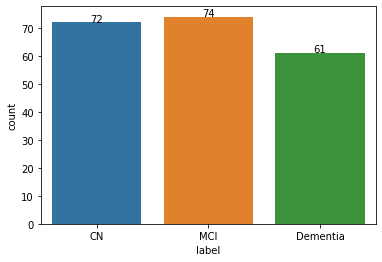

In [4]:
graph = sns.countplot(x="label", data=pet_data_df);
for p in graph.patches: 
    height = p.get_height()
    graph.text(p.get_x() + p.get_width()/2., height + 0.2, height, ha="center")


In [5]:
encoder = preprocessing.LabelEncoder()
pet_data_df['label']= encoder.fit_transform(pet_data_df['label'])
pet_data_df['label'].unique()
pet_data_df.head()
pet_data_df_fi =pet_data_df

### Feature selction using Univariate Selection

In [6]:
X = pet_data_df.iloc[:,0:35]
y = pet_data_df.iloc[:,-1]  

In [7]:
bestfeatures = SelectKBest(score_func=chi2, k=14)
fit = bestfeatures.fit(X, y)
dfscores = pd.DataFrame(fit.scores_)

In [8]:
dfcolumns = pd.DataFrame(X.columns)
# concat two df for visualization 
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs','Score'] 
#print top 10 features
print(featureScores.nlargest(10,'Score'))  

          Specs      Score
34  MMSCORE_m36  59.133971
33  MMSCORE_m24  38.577862
32  MMSCORE_m12  16.494915
31  MMSCORE_m06  11.221813
30   MMSCORE_sc   4.554861
4        CP_MAX   1.216650
1     CP_MEDIAN   1.054037
0       CP_MEAN   1.009330
10       AL_MAX   0.914336
7     AL_MEDIAN   0.740034


In [9]:
columns = featureScores.nlargest(10,'Score')['Specs'].tolist()
columns.append('label')
pet_data_df = pet_data_df[columns]
pet_data_df.head()

,MMSCORE_m36,MMSCORE_m24,MMSCORE_m12,MMSCORE_m06,MMSCORE_sc,CP_MAX,CP_MEDIAN,CP_MEAN,AL_MAX,AL_MEDIAN,label
0,30,29,30,29,29,1.59085,1.46006,1.42132,1.48234,1.38456,0
1,29,30,28,29,29,1.71550,1.43394,1.35138,1.39319,1.22393,0
2,26,28,30,29,28,1.86328,1.64769,1.63455,1.71677,1.52008,0
3,30,29,30,29,30,1.65001,1.41541,1.37415,1.67836,1.47777,0
4,28,29,28,28,26,1.68188,1.47362,1.43045,1.55640,1.40453,0


In [10]:
X_pet, y_pet = np.split(pet_data_df.to_numpy(), [-1], axis=1) 

### Split the dataset into train and test data using 85:15 split

In [11]:
X_train_pet, X_test_pet, y_train_pet, y_test_pet = train_test_split(X_pet, y_pet, test_size=0.15, random_state=44)


### Scaling

In [12]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train_pet = min_max_scaler.fit_transform(X_train_pet)
X_test_pet = min_max_scaler.transform(X_test_pet)

### SVM Classifier

In [13]:
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train_pet, y_train_pet)
svm_predictions = svm_model_linear.predict(X_test_pet)

print("Classification report: ")
print(classification_report(y_test_pet , svm_predictions))

Classification report: 
              precision    recall  f1-score   support

         0.0       0.50      0.90      0.64        10
         1.0       0.75      1.00      0.86         6
         2.0       0.83      0.31      0.45        16

    accuracy                           0.62        32
   macro avg       0.69      0.74      0.65        32
weighted avg       0.71      0.62      0.59        32



/Users/shrutidudwadkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [14]:
rmse = sqrt(mean_squared_error(y_test_pet , svm_predictions))
print("RMSE: ", rmse)

RMSE:  1.14564392373896


### Decision Tree Classifier

In [15]:
dtree_model = DecisionTreeClassifier(max_depth = 2)
dtree_model.fit(X_train_pet, y_train_pet)
dtree_predictions = dtree_model.predict(X_test_pet)

print("Classification report: ")
print(classification_report(y_test_pet , dtree_predictions))

Classification report: 
              precision    recall  f1-score   support

         0.0       0.57      0.80      0.67        10
         1.0       0.46      1.00      0.63         6
         2.0       0.80      0.25      0.38        16

    accuracy                           0.56        32
   macro avg       0.61      0.68      0.56        32
weighted avg       0.67      0.56      0.52        32



In [16]:
auc = roc_auc_score(y_test_pet, dtree_model.predict_proba(X_test_pet), multi_class='ovr')
print("AUC: ", auc)

AUC:  0.7695021124708624


In [17]:
rmse = sqrt(mean_squared_error(y_test_pet , dtree_predictions))
print("RMSE: ", rmse)

RMSE:  1.0458250331675945


### Gaussian NB Classifier

In [18]:
gnb = GaussianNB()
gnb.fit(X_train_pet, y_train_pet)
gnb_predictions = gnb.predict(X_test_pet)

print("Classification report: ")
print(classification_report(y_test_pet , gnb_predictions))

Classification report: 
              precision    recall  f1-score   support

         0.0       0.62      0.80      0.70        10
         1.0       0.75      1.00      0.86         6
         2.0       0.82      0.56      0.67        16

    accuracy                           0.72        32
   macro avg       0.73      0.79      0.74        32
weighted avg       0.74      0.72      0.71        32



/Users/shrutidudwadkar/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [19]:
auc = roc_auc_score(y_test_pet, gnb.predict_proba(X_test_pet), multi_class='ovr')
print("AUC: ", auc)

AUC:  0.8352497329059828


In [20]:
rmse = sqrt(mean_squared_error(y_test_pet , gnb_predictions))
print("RMSE: ", rmse)

RMSE:  0.9682458365518543


## Model Results
### Univariate Selection on PET + MMSE dataset

| Model | Precision  | Recall  | F1-Score  | Accuracy 
|:-:|:-:|:-:|:-:|:-:|
| SVM Classifier  | 0.69 | 0.74  | 0.65  | 0.62  |
| Decision Tree Classifier  | 0.61 | 0.68 | 0.56 | 0.56 |
| Gaussian NB Classifier  | **0.73** | **0.79**  | **0.74**  | **0.72**  |
